# Random Forest

This notebook will be used to tune and evaluate the Random Forest model.

We will tune the model hyperparameters using crossvalidation and considering two different scores: balanced_accuracy and f1_weighted.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, balanced_accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.model_datatransforms import *

---
# Data Loading

In [2]:
df = pd.read_parquet('data/pred_model_data_full.parquet')

In [4]:
df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Unsupported                       20791
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Music non-amplified                 126
Nature elements - Wind              113
Name: noise_event_laeq_primary_detected_class, dtype: int64

Since we have fewer observations for 'Music non-amplified' and 'Nature elements - Wind', and that the level of certainty that these observations are being correctly classified is lower than for the other classes, we will join these classes to 'Unsupported' and call the new class 'Other'

In [3]:
conditions = df['noise_event_laeq_primary_detected_class'].isin(['Music non-amplified', 'Nature elements - Wind', 'Unsupported'])
df.loc[conditions, 'noise_event_laeq_primary_detected_class'] = 'Other'

df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Other                             21030
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [6]:
X = df.drop(columns=['noise_event_laeq_primary_detected_class'])

le = LabelEncoder()
y = le.fit_transform(df[['noise_event_laeq_primary_detected_class']])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

c:\Users\anaso\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---
# balanced_accuracy

In [100]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'])
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [101]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.617005061663432

Hyperparameter tuning

In [102]:
n_estimators = np.arange(400, 550, 50) 
max_depth = np.arange(10,18,3) 
min_samples_split = np.arange(18,30,3)
ccp_alpha = np.array([1e-11, 1e-9, 1e-7])

random_grid = {
    'month_handler__strategy': ['month','season'], 
    'day_of_the_week_handler__strategy': ['full','weekend'],
    'custom_encoder__strategy': ['one_hot','binary'], 
    'randomForest__n_estimators': n_estimators,
    'randomForest__max_depth': max_depth,
    'randomForest__min_samples_split': min_samples_split,
    'randomForest__ccp_alpha': ccp_alpha   
}

In [104]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=150, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.620470692749183
Best Parameters: {'randomForest__n_estimators': 500, 'randomForest__min_samples_split': 27, 'randomForest__max_depth': 10, 'randomForest__ccp_alpha': 1e-11, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

We include in the pipeline the best hyperparameters obtained

In [4]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=500, min_samples_split=27, max_depth=10, ccp_alpha=1e-11))
])

In [7]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                         'lceq_shift_t-_5',
        

In [107]:
y_pred = pipeline.predict(X_test)

In [8]:
y_pred_proba = pipeline.predict_proba(X_test)

Obtain accuracy and balanced accuracy scores

In [109]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.6600776866637894
Balanced Accuracy: 0.622953597716341


In [9]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.8601824648240004

Confusion matrix

In [111]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

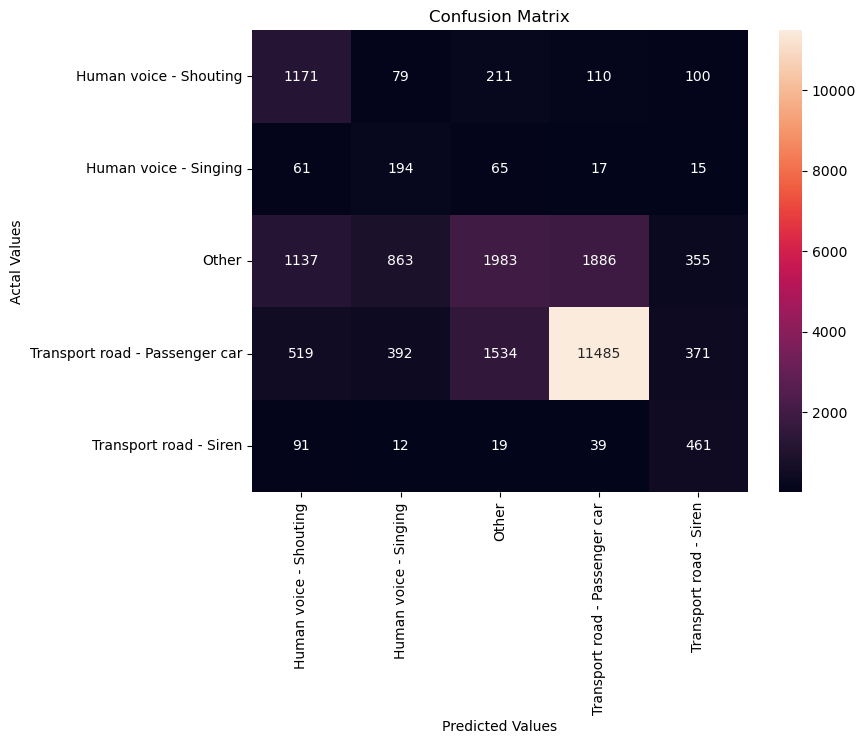

In [112]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

Classification report

In [113]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.39      0.70      0.50      1671
         Human voice - Singing       0.13      0.55      0.21       352
                         Other       0.52      0.32      0.40      6224
Transport road - Passenger car       0.85      0.80      0.83     14301
        Transport road - Siren       0.35      0.74      0.48       622

                      accuracy                           0.66     23170
                     macro avg       0.45      0.62      0.48     23170
                  weighted avg       0.70      0.66      0.67     23170



---
# f1_weighted

In [55]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'])
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [56]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.6144985406518084

Hyperparameter tuning

In [57]:
n_estimators = np.arange(300, 500, 50) 
max_depth = np.arange(25,45,5) 
min_samples_split = np.arange(5,15,3)
ccp_alpha = np.array([1e-11, 1e-9, 1e-7])

random_grid = {
    'month_handler__strategy': ['month','season'], 
    'day_of_the_week_handler__strategy': ['full','weekend'], 
    'custom_encoder__strategy': ['one_hot','binary'], 
    'randomForest__n_estimators': n_estimators,
    'randomForest__max_depth': max_depth,
    'randomForest__min_samples_split': min_samples_split,
    'randomForest__ccp_alpha': ccp_alpha   
}

In [58]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=150, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.7428675907245258
Best Parameters: {'randomForest__n_estimators': 350, 'randomForest__min_samples_split': 8, 'randomForest__max_depth': 30, 'randomForest__ccp_alpha': 1e-09, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

We include in the pipeline the best hyperparameters obtained

In [10]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=350, min_samples_split=8, max_depth=30, ccp_alpha=1e-09))
])

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                         'lceq_shift_t-_5',
        

In [61]:
y_pred = pipeline.predict(X_test)

In [12]:
y_pred_proba = pipeline.predict_proba(X_test)

Obtain accuracy and balanced accuracy scores

In [63]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.7593439792835563
Balanced Accuracy: 0.5161539801674657


In [14]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.9092233697860197

Confusion matrix

In [65]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

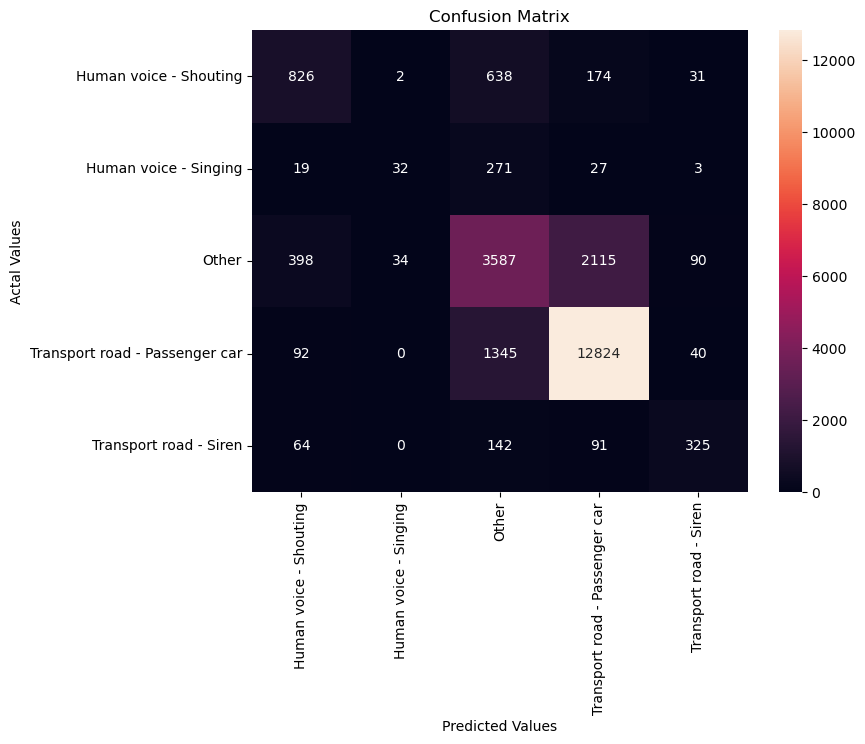

In [66]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

Classification report

In [67]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.59      0.49      0.54      1671
         Human voice - Singing       0.47      0.09      0.15       352
                         Other       0.60      0.58      0.59      6224
Transport road - Passenger car       0.84      0.90      0.87     14301
        Transport road - Siren       0.66      0.52      0.59       622

                      accuracy                           0.76     23170
                     macro avg       0.63      0.52      0.55     23170
                  weighted avg       0.75      0.76      0.75     23170

